In [1]:
import time
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.special import softmax, erf
from scipy.optimize import minimize, root

# Andmed
Aasta 2023 juulist septembrini kestnud sõduri baaskursuse ajal kirja pandud spioonide ning ka mittespioonide toimumiskuupäevad ning -ajad. 

In [28]:
def build_df(filename: str) -> pl.DataFrame:
    return pl.read_csv(filename, try_parse_dates=True).with_columns(
        (pl.col('kuupäev') - pl.col('kuupäev').dt.strftime('%Y-%m-%d').str.strptime(pl.Datetime)).dt.total_minutes().alias('t') / 60,
        pl.col('kuupäev').dt.ordinal_day().alias('m')).with_columns(
        pl.first('m').over('m').rank('dense').alias('m') - 1
    ).drop('kuupäev')

In [29]:
df = build_df('andmed/spioonid.csv')
df.head()

t,m
f64,u32
14.183333,0
17.5,0
18.533333,0
21.566667,0
22.083333,0


# Taust
Kirjeldatud meetod põhineb [Goulding et al.](https://www.cs.nott.ac.uk/~pszgss/goulding2016event_preprint.pdf)

Mittehomogeenset Poissoni protsessi kirjeldab ajast sõltuv intensiivsus $\lambda(t)$, see on ka näide loendavast protsessist, mida on võimalik defineerida kahe ajahetke $t_1$ ning $t_2$ vaheliste sündmuste arvu esinemise tõenäosuse kaudu
\begin{align*}
    &P(N(t_1, t_2) = c) = \frac{ \Lambda(t_1, t_2)^c}{c!} e^{- \Lambda(t_1, t_2)} \\
    \text{kus} \quad &\Lambda(t_1, t_2) = \int_{t_1}^{t_2} \lambda(t) dt
\end{align*}
Intensiivsusfunktsiooni kaudu on võimalik avaldada jaotusfunktsioon $F^s(t)$, mis kirjeldab oodatavat aega hetkest $s$ kuni uue sündmuse toimumiseni
\begin{equation*}
    F^s(t) = 1 - e^{\Lambda(s, s + t)}
\end{equation*}
Jaotusfunktsiooni on võimalik kasutada ennustamiseks, lisaks on selle põhjal võimalik leida sündmusrea $\textbf{t}_i = \langle t_{i0} , t_{i1} , \dots , t_{ij} \rangle$ ühisjaotuse tihedus $f(\textbf{t}_i)$, mis kirjeldab tõenäosust, et rida pärineb sellelt protsessilt.
\begin{equation*}
    f(\textbf{t}_i | \tau) = e^{- \Lambda (0 , \tau) } \prod_{j = 1}^n \lambda (t_{ij})
\end{equation*}
kus $\tau$ tähistab protsessi indekshulga vähimat ülemist tõket.

# Mudel
Formaalselt võib eelnevat andmestikku kirjeldada sündmusridade hulgana $\mathcal{T} = \{ \textbf{t}_1 , \textbf{t}_2 , \dots , \textbf{t}_m \}$, mille realisatsioonid $\textbf{t}_i = \langle t_{i0} , t_{i1} , \dots , t_{ij} \rangle$ pärinevalt mingilt mittehomogeense Poissoni liitprotsessi alamprotsessilt.

Andmestikku modelleerime $Z$ alamprotsessist koosneva MHPP liitprotsessina, mille alamprotsesside intesiivsused on $K$ kaalutud normaaljaotustiheduste summad 
\begin{align*}
    &\lambda_z(t) = \sum_{k = 1}^K a_{z k} B_k(t) \\
    \text{kus} \quad &B_k(t) = \frac{1}{\sigma_k \sqrt{2 \pi}} \exp \left( - \frac{(t - \mu_k)^2}{2 \sigma_k^2} \right) \\
    \text{ning} \quad &\mu_k = \frac{(k - 1) \tau}{K - 1} , \qquad \sigma_k = \frac{\tau}{k} 
\end{align*}

In [4]:
def rate(t, weights, locs, scales):
    return np.sum(weights * norm.pdf(t, loc=locs, scale=scales))


def joint_pdf(t_vec, weights, locs, scales):
    rate_cdf = -np.sum(weights * norm.cdf(24 * 60, loc=locs, scale=scales))
    rates_t = [rate(t, weights, locs, scales) for t in t_vec]
    return np.exp(rate_cdf) * np.prod(rates_t)

## Parameetrite sobitamine
Toodud ehitusklotside põhjal taandub mudeli loomine kaalude $a_{zk}$ leidmisele. Kaalude leidmiseks vaatame parameetrite suhtes mudeli tõepära funktsiooni. Igale alamprotsessile $N_z(t)$ seame vastavusse segandumis tõenäosuse $p_z$, mis kirjedab võimalust, et mingi sündmusterida hulgas $\mathcal{T}$ pärineb sellelt alamprotsessilt. Eelnevast lähtudes on kogu mudeli tõepära funktsioon
\begin{equation*}
    \mathcal{L}(\theta | \mathcal{T}) = \prod_{i = 1}^m \sum_{z = 1}^Z p_z f_z(\textbf{t}_i | \tau)
\end{equation*}
kus $\theta = \langle \lambda_1 , \lambda_2 , \dots , \lambda_Z \rangle$.
Järgnevalt leiame mudeli kaalud iteratiivselt, kasuted EM (expectation maximization) meetodit. Alustades algsete parameetritega $\theta^0$ (siin tähistame $r$-indat iteratsioonisammu kujul $\theta^r$).

In [5]:
def log_likelihood(event_series, weights, locs, scales, mix_probs, orig_probs):    
    ll = 0
    for i, z in np.ndindex(orig_probs.shape):
        t_vec = event_series[i]
        ll += orig_probs[(i, z)] * np.log(mix_probs[z] * joint_pdf(t_vec, weights[z], locs, scales))
    
    return ll

### Ooteväärtuse samm
Antud parameetrivektori $\theta^r$ korral leiame iga alamprotsessi jaoks tõenäosused, et sündmuste rida $\textbf{t}_i$ pärineb sellelt alamprotsessilt
\begin{equation*}
    p_{iz}^r = \frac{ e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) }{ \sum_{q = 1}^{Z} e^{- \Lambda_q (0 , \tau)} \prod_{j = 1}^n \lambda_q (t_{ij}) }
\end{equation*}

In [6]:
def expectation_step(event_series, weights, locs, scales, orig_probs):
    for i, z in np.ndindex(orig_probs.shape):
        t_vec = event_series[i]
        joint_densities = [joint_pdf(t_vec, w_vec, locs, scales) for w_vec in weights]
        
        orig_probs[(i, z)] = joint_densities[z] / np.sum(joint_densities)
    
    return orig_probs

### Maksimeerimise samm
Saadud pärinemistõenäosustega leiame uued parameetrite lähendid $\theta^{r + 1}$ suurima logaritm tõepära meetodil
\begin{equation*}
    \theta^{r + 1} = \underset{\theta}{\arg \max} \left[ \sum_{i = 1}^m \sum_{z = 1}^Z p_{iz} \ln \left( p_z e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) \right) \right]
\end{equation*}
paramaeetrid leiame numbriliselt.

Järgmised hinnangud segandumistõenäosustele leiame lihtsa aritmeetilise keskmisena pärinemistõenäosustest
\begin{equation*}
    p_z^{r + 1} = \frac{1}{n} \sum_{i = 1}^m p_{iz}^r
\end{equation*}

In [7]:
def maximisation_step(event_series, weights, locs, scales, mix_probs, orig_probs):    
    def _ll(_theta):
        return -log_likelihood(event_series, _theta.reshape(weights.shape), locs, scales, mix_probs, orig_probs)

    theta = weights.flatten()
    bounds = ((0.1, np.inf) for _ in theta)
    optimize_result = minimize(_ll, theta, bounds=bounds)
    
    weights = optimize_result['x'].reshape(weights.shape)
    mix_probs = orig_probs.mean(axis=0)
    
    return weights, mix_probs, optimize_result

EM meetodi iteratsioonisamme kordame kuni kindla sammude arvuni. Mudeli sobitamiseks kasutame olekut talletavat abiklassi.

In [13]:
class State:
    def __init__(self, data: pl.DataFrame, n_base: int, n_process: int) -> State:
        self.event_series = data.group_by('m').all().sort(pl.col('m'))['t'].to_numpy()

        self.n_series = self.event_series.shape[0]
        self.n_base = n_base
        self.n_process = n_process
        
        __k = np.arange(1, self.n_base + 1)
        __tau = 24 * 60
        self.locs = ((__k - 1) * __tau) / (self.n_base - 1)
        self.scales = __tau / __k
        
        self.__prev_weights = np.clip(norm.rvs(loc=1, scale=1, size=(self.n_process, self.n_base)), 0.1, 10)
        self.weights = self.__prev_weights
        self.orig_probs = softmax(np.zeros((self.n_series, self.n_process), dtype=np.longdouble))
        self.mix_probs = np.mean(self.orig_probs, axis=0)
        
        self.__iterations = 0


    def fit(self, iterations: int, verbose=False):
        while iterations > 0:
            self.__it(verbose=verbose)
            iterations -= 1
            self.__iterations += 1

    
    def __it(self, verbose=False):
        self.__prev_weights = self.weights

        e_start = time.time()
        self.orig_probs = expectation_step(self.event_series, 
                                           self.__prev_weights, 
                                           self.locs, 
                                           self.scales, 
                                           self.orig_probs)
        e_time = time.time() - e_start

        m_start = time.time()
        self.weights, self.mix_probs, _ = maximisation_step(self.event_series, 
                                                            self.__prev_weights, 
                                                            self.locs, 
                                                            self.scales, 
                                                            self.mix_probs, 
                                                            self.orig_probs)
        m_time = time.time() - m_start
        
        if verbose:
            diff = self.weights - self.__prev_weights
            diff_norm = np.linalg.norm(diff, ord=np.inf)
            print(f'| iteration={self.__iterations} \t| diff={diff_norm:.4f} \t| E={e_time:.4f}s \t| M={m_time:.4f}s \t|')


model_state = State(df, 50, 10)

In [14]:
model_state.fit(5, verbose=True)

| iteration=0 	| diff=89.4124 	| E=1.3384s 	| M=2561.1561s 	|
| iteration=1 	| diff=3.2807 	| E=1.6518s 	| M=2454.0710s 	|


### Mudel visuaalselt

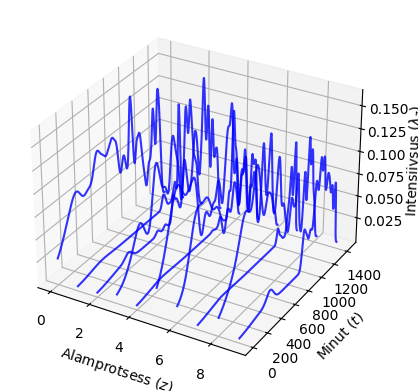

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for sub_process in range(model_state.n_process):
    ts = np.linspace(0, 24, 500)
    sub_process_rate = [rate(t, model_state.weights[sub_process], model_state.locs, model_state.scales) for t in ts]
    
    ax.plot(ts, sub_process_rate, zs=sub_process, zdir='x', color='b', alpha=0.8)

ax.set_xlabel('Alamprotsess $(z)$')
ax.set_ylabel('Tund $(t)$')
ax.set_zlabel('Intensiivsus $(\\lambda_z)$')

fig.savefig(f'z-{model_state.n_process}_k-{model_state.n_base}.png', dpi=100)

## Mudeli kasutamine
Ennustamaks järgmise sündmuse toimumishetke sündmusreas $\textbf{t}$, peame kõigepealt nimetatud sündmusrea seostama mudeli mingi alamprotsessiga. Soovitud alamprotsessi $z$ valime suurima tõepära meetodiga
\begin{equation*}
    z = \underset{z \in \{ 1 , 2 , \dots , Z \} }{\arg \max} f_z(\textbf{t} | \tau)
\end{equation*}

In [16]:
test_df = build_df('andmed/spioonid_kunstlik.csv')
test_times = test_df.group_by('m').all().sort(pl.col('m'))['t'].to_numpy()[5]

sub_process = np.argmax([joint_pdf(test_times, 
                                   model_state.weights[sub_process], 
                                   model_state.locs, 
                                   model_state.scales) for sub_process in range(model_state.n_process)])

### Aeg järgmise sündmuseni
Kui oleme leidnud võimalik sündmusrea tootnud alamprotsessi, ennustame aega järgmise sündmuse toimumiseni $\eta$ alamprotsessi jaotuse mediaanina
\begin{align*}
    F_z^s(\eta) = 1 - e^{\Lambda_z(s , s + \eta)} &= \frac{1}{2} \\
    \Lambda_z(s , s + \eta) - \ln 2 &= 0
\end{align*}

Tehes asendused ning integreerimse jõuame võrrandini
\begin{equation*}
    \sum_{k = 1}^K \frac{a_{zk}}{2} \left[ \text{erf} \left( \frac{s + \eta - \mu_k}{\sqrt{2} \sigma_k} \right) - \text{erf} \left( \frac{s - \mu_k}{\sqrt{2} \sigma_k} \right) \right] - \ln 2 = 0
\end{equation*}
Kuna kõik muutujad peale $\eta$ on teada, saame lähendi leida kiiresti kasutades numbrilisi meetodeid.

In [21]:
def cdf_expression(eta, from_t, process_weights, locs, scales, quantile=0.5):
    q_log = np.log(1 / quantile)
    scaled_weights = process_weights / 2
    numerator = from_t - locs
    denominator = np.sqrt(2) * scales
    return np.sum(scaled_weights * (erf((numerator + eta) / denominator) - erf(numerator / denominator))) - q_log

In [23]:
from_time = 16.5
args = (from_time, model_state.weights[sub_process], model_state.locs, model_state.scales)
root_result = root(cdf_expression, 0, args=args)
wait_time = root_result['x'][0]

print(f'praegune aeg: {from_time}h\nennustatud ooteaeg: {wait_time:.2f}h')

praegune aeg: 16.50h
ennustatud ooteaeg: 0.29h
